<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/imdb_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0" #use the old version

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 43.7MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [2]:
!pip install ipdb
from ipdb import set_trace as st

In [3]:
from fastai import *
from fastai.text import *

In [5]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/unsup')]

In [7]:
#test
(path/'train'/'pos').ls()[:10]

[PosixPath('/root/.fastai/data/imdb/train/pos/8877_9.txt'),
 PosixPath('/root/.fastai/data/imdb/train/pos/8480_10.txt'),
 PosixPath('/root/.fastai/data/imdb/train/pos/3287_9.txt'),
 PosixPath('/root/.fastai/data/imdb/train/pos/8627_10.txt'),
 PosixPath('/root/.fastai/data/imdb/train/pos/8990_10.txt'),
 PosixPath('/root/.fastai/data/imdb/train/pos/4562_9.txt'),
 PosixPath('/root/.fastai/data/imdb/train/pos/10679_10.txt'),
 PosixPath('/root/.fastai/data/imdb/train/pos/6682_10.txt'),
 PosixPath('/root/.fastai/data/imdb/train/pos/11405_8.txt'),
 PosixPath('/root/.fastai/data/imdb/train/pos/821_10.txt')]

In [15]:
#language model learner
src_lm = TextList.from_folder(path, include = ['train', 'test']).split_by_rand_pct().label_for_lm()
data_lm = src_lm.databunch()

In [14]:
#test
src_lm

LabelLists;

Train: LabelList (40000 items)
x: LMTextList
xxbos xxmaj as a physicist , talk about xxunk and cosmology gets my heart racing . xxmaj however i found this presentation too slow and not packed with enough information for the interested layman ( who is most likely to see it ) . xxmaj if you have more than a passing curiosity in this sort of stuff , go to the library and check out some books . xxmaj you will find they explain current scientific xxunk with far more detail while at the same time filling you with more of a sense of wonder than this movie does . xxmaj also to set the record straight : xxmaj hawking is xxup not considered the " greatest mind " or the world 's " smartest person " as commonly asserted even among the user reviews here at the imdb . xxmaj hawking himself has commented that " xxmaj it is rubbish . xxmaj it is just media hype . xxmaj they needed somebody to fill the role model of disabled genius . xxmaj at least i 'm disabled . " xxmaj to be fair , he i

In [16]:
data_lm.show_batch()

idx,text
0,"you will find they explain current scientific xxunk with far more detail while at the same time filling you with more of a sense of wonder than this movie does . xxmaj also to set the record straight : xxmaj hawking is xxup not considered the "" greatest mind "" or the world 's "" smartest person "" as commonly asserted even among the user reviews here at the imdb"
1,"the camera : "" dirty ho "" , everything but the rim shot was missing , and even that would n't have helped . \n \n xxmaj the same folks who created ' xxmaj whoville ' , clearly had a hand in the creation of the town and the houses in ' xxmaj cat ' . xxmaj the sets and props were very appealing , giving the viewer a"
2,"was n't feeling too annoyed , the movie was unintentionally quite hilarious once in a while , as it showed xxmaj holland at its smallest . xxbos xxmaj first off , i saw another reviewer said this movie was "" fantastic "" . xxmaj well nothing could be further from the truth ! xxmaj this movie is complete garbage ! ! ! a moronic horror comedy that is xxup not"
3,"they seem to be made purely because they fit the financial criteria rather than had any potential audience . a lucky few get a week at a small screen in xxmaj london before going to budget xxup dvd , but xxmaj the xxmaj riddle distinguished itself by completely xxunk cinema , xxup tv or even the rental market to premiere as a free gift xxup dvd in the xxmaj mail"
4,"slasher films on xxup vhs because the cover artwork is fantastic . xxmaj usually though , it turns out that the film itself is less than fantastic . xxmaj the xxmaj prey is one of those films . \n \n xxmaj to be fair , it started off xxup ok , with the killer stalking the cliché teenagers in the woods . xxmaj the heartbeat sounds used are a"


In [18]:
for x, y in data_lm.train_dl: break

In [19]:
#test
x, y 

(tensor([[   10,     5, 12906,  ...,     0,    11,    12],
         [ 7140,    53,     9,  ...,     5,   663,     9],
         [   77,  1076,   174,  ...,   115,    13,  8842],
         ...,
         [ 5503,    12,    15,  ...,    22,   192, 29409],
         [  628,  1859,    11,  ...,  4411,    32,    11],
         [  116,  5978,    34,  ...,    56,   483,    49]], device='cuda:0'),
 tensor([[    5, 12906,   337,  ...,    11,    12,   129],
         [   53,     9,    98,  ...,   663,     9,     6],
         [ 1076,   174,    49,  ...,    13,  8842,   391],
         ...,
         [   12,    15,  9672,  ...,   192, 29409,    11],
         [ 1859,    11,    17,  ...,    32,    11,    58],
         [ 5978,    34,   152,  ...,   483,    49,     5]], device='cuda:0'))

In [23]:
voc = data_lm.vocab
len(voc.itos)

47496

In [24]:
#test
doc(language_model_learner)

In [29]:
arch = AWD_LSTM
arch.__dict__

mappingproxy({'__doc__': 'AWD-LSTM/QRNN inspired by https://arxiv.org/abs/1708.02182.',
              '__init__': <function fastai.text.models.awd_lstm.AWD_LSTM.__init__>,
              '__module__': 'fastai.text.models.awd_lstm',
              '_one_hidden': <function fastai.text.models.awd_lstm.AWD_LSTM._one_hidden>,
              'forward': <function fastai.text.models.awd_lstm.AWD_LSTM.forward>,
              'initrange': 0.1,
              'reset': <function fastai.text.models.awd_lstm.AWD_LSTM.reset>,
              'select_hidden': <function fastai.text.models.awd_lstm.AWD_LSTM.select_hidden>})

In [30]:
learn_lm = language_model_learner(data_lm, arch, pretrained= True, drop_mult=0.3)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


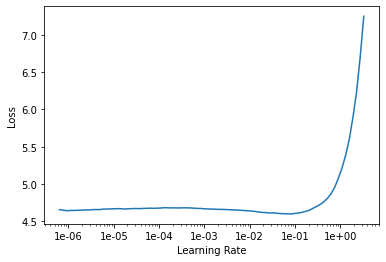

In [31]:
learn_lm.lr_find()
learn_lm.recorder.plot()

In [33]:
learn_lm.fit_one_cycle(2, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,4.204300,4.071762,0.287401,05:11
1,3.997254,3.943815,0.299049,05:12


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


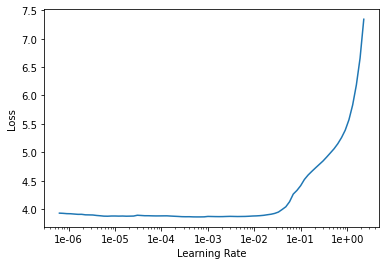

In [34]:
learn_lm.unfreeze()
learn_lm.lr_find()
learn_lm.recorder.plot()

In [35]:
learn_lm.fit_one_cycle(2, 1e-03)

epoch,train_loss,valid_loss,accuracy,time
0,3.776662,3.785966,0.317828,05:57
1,3.600149,3.717384,0.326492,05:57


In [36]:
learn_lm.save_encoder('fine_tuned')

In [46]:
#now NLP classifier
src = TextList.from_folder(path, include = ['train', 'test'], vocab = data_lm.vocab).split_by_folder(valid = 'test').label_from_folder(classes = ['pos', 'neg'])
data = src.databunch()

In [47]:
data.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj warning : xxmaj does contain spoilers . \n \n xxmaj open xxmaj your xxmaj eyes \n \n xxmaj if you have not seen this film and plan on doing so , just stop reading here and take my word for it . xxmaj you have to see this film . i have seen it four times so far and i still have n't made up my",pos
"xxbos xxup anchors xxup aweigh sees two eager young sailors , xxmaj joe xxmaj brady ( xxmaj gene xxmaj kelly ) and xxmaj clarence xxmaj doolittle / xxmaj brooklyn ( xxmaj frank xxmaj sinatra ) , get a special four - day shore leave . xxmaj eager to get to the girls , particularly xxmaj joe 's xxmaj lola , neither xxmaj joe nor xxmaj brooklyn figure on the interruption",pos
"xxbos xxunk ) is the developing world 's answer to xxmaj silence of the xxmaj lambs . xxmaj where ` xxmaj silence ' terrorized our peace of mind , ` xxmaj citizen ' exhausts and saddens us instead . xxmaj this dramatization of the xxmaj chikatilo case translates rather well , thanks to a xxmaj westernized friendship between two xxmaj rostov cops who become equals . \n \n citizenx",pos
"xxbos xxmaj office work , especially in this era of computers , multi - functional copy machines , e - mail , voice mail , snail mail and ` temps , ' is territory ripe with satirical possibilities , a vein previously tapped in such films as ` xxmaj xxunk ' and ` xxmaj office xxmaj space , ' and very successfully . xxmaj this latest addition to the temp",neg


In [51]:
#test
data_lm = src_lm.databunch()
learn_lm = language_model_learner(data_lm, arch, drop_mult = 0.3)
learn_lm.load('fine_tuned')
learn_lm.save_encoder('fine_enc')

In [52]:
learn_lm = None
data_lm = None
gc.collect()

93

In [ ]:
learn = text_classifier_learner(data, arch, drop_mult = 0.3)
learn.load_encoder('fine_enc') 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


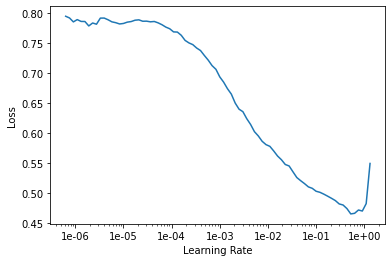

In [54]:
learn.lr_find()
learn.recorder.plot()

In [55]:
lr, new_lr = 3e-02, 2e-03

In [56]:
learn.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.298748,0.259053,0.898720,01:36
1,0.269086,0.224575,0.908960,01:38


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


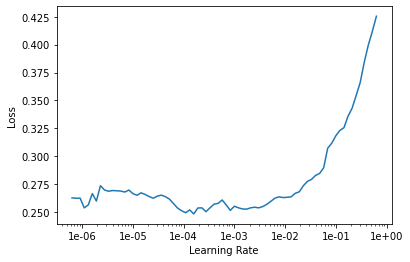

In [57]:
learn.save('stage_1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [59]:
learn.fit_one_cycle(10, 1e-03)

epoch,train_loss,valid_loss,accuracy,time
0,0.023620,0.226539,0.932520,03:11
1,0.034979,0.244642,0.927360,02:43
2,0.039197,0.318953,0.909880,02:58
3,0.029498,0.322379,0.917920,03:09
4,0.026992,0.331342,0.921000,02:57
5,0.011977,0.338810,0.926040,03:00
6,0.008789,0.335589,0.928000,03:02
7,0.005584,0.362975,0.927040,03:02
8,0.001221,0.363702,0.926960,02:58
9,0.001586,0.368670,0.926960,02:51


In [62]:
learn.predict('chris nolan is amazing')

(Category tensor(0), tensor(0), tensor([0.6025, 0.3975]))